# Create a dataset of XYZA images that can be trained by the deep learning regression network

Before we can train the deep learning regression network, we first need to create a dataset of XYZA images. 
<br>
XYZA images are 4-channel images from which we want to estimate the real-world diameter (with deep learning regression). 
<br>
<br>
The XYZA images consist of the following channels:
<br>
Channel 1: x-coordinates of the visible mask (in millimeters, datatype=np.float32)
<br>
Channel 2: y-coordinates of the visible mask (in millimeters, datatype=np.float32)
<br>
Channel 3: z-coordinates of the visible mask (in millimeters, datatype=np.float32)
<br>
Channel 4: amodal mask (binary image, datatype=np.float32)

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from numpy.linalg import inv
import os
import cv2
import random
import tifffile
from pyexcel_ods import get_data
import csv
import json
from tqdm import tqdm
import time
import seaborn as sns
import pandas as pd

# import some miscellaneous libraries
from utils import visualize
from utils import statistics

# import the libraries that are needed for the deep learning regression
import torch
from torch.autograd import Variable
from torchvision import transforms
import skimage.transform

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()

## Specify the directories, file locations, etc. (user input is needed here!)

In [2]:
rootdir = "./datasets/train_val_test_files"
imgfolder = os.path.join(rootdir, "orcnn")
xyzimgdir = os.path.join(rootdir, "regression")

subfolders = ["train", "val"]
store_folder = "xyza_mask_images"

gtfile = os.path.join(rootdir, "groundtruth_measurements_broccoli.ods") ## comment out if there is no ground truth file (also restart the kernel)
try:
    gt = get_data(gtfile)
    gt_file_present = True
except:
    gt_file_present = False

## Initialize the image inference

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_orcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

cfg.OUTPUT_DIR = "weights/20201109_broccoli_amodal_visible"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0007999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TRAIN = ("broccoli_amodal_train",)
cfg.DATASETS.TEST = ("broccoli_amodal_val",)

predictor = DefaultPredictor(cfg)

## Extract the biggest dimension from all annotations, such that the created masks will fit into the newly created XYZA image

In [4]:
max_dimension = 0
for j in range(len(subfolders)):
    subfolder = subfolders[j]

    imagefolder = os.path.join(imgfolder, subfolder)
    annotationfile = os.path.join(imagefolder, "annotations.json")

    register_coco_instances("broccoli_" + subfolder, {}, annotationfile, imagefolder)
    broccoli_amodal_metadata = MetadataCatalog.get("broccoli_" + subfolder)
    dataset_dicts = DatasetCatalog.get("broccoli_" + subfolder)

    for i in range(len(dataset_dicts)):
        d = dataset_dicts[i]
        max_dimensions = []
        for k in range(len(d["annotations"])):
            max_dimensions.append(max(d["annotations"][k]['bbox'][2], d["annotations"][k]['bbox'][3]))

        if np.max(max_dimensions) > max_dimension:
            max_dimension = np.max(max_dimensions)
            
zeropad_dimension = int(statistics.ceil_to_25(max_dimension))
print("")
print("Zero-pad size dimension set to: {0:d}".format(zeropad_dimension))

# Write the zero-pad dimension so it can be used for regression inference as well
writedir = os.path.join(rootdir, store_folder)
if not os.path.exists(writedir):
    os.makedirs(writedir)

txtfile = open(os.path.join(writedir,"zeropad_dimension.txt"),"w")
txtfile.write("{0:d}".format(zeropad_dimension))
txtfile.close()

[11/18 15:14:16 d2.data.datasets.coco]: Loaded 1569 images in COCO format from ./datasets/train_val_test_files/orcnn/train/annotations.json
[11/18 15:14:16 d2.data.datasets.coco]: Loaded 504 images in COCO format from ./datasets/train_val_test_files/orcnn/val/annotations.json

Zero-pad size dimension set to: 600


## Function to find the broccoli head that belongs to the ground truth

In [5]:
def find_closest_object(boxes, boxmethod, coordinates_broccoli_gt, gt_data_present):
    distances = []
    if np.logical_and(boxes.size > 0, gt_data_present):
        for h in range(len(boxes)):
            box = boxes[h]
            
            if boxmethod == "XYXY":
                x_center = box[0] + ((box[2] - box[0]) / 2)
                y_center = box[1] + ((box[3] - box[1]) / 2)
            elif boxmethod == "XYWH":
                x_center = box[0] + (box[2] / 2)
                y_center = box[1] + (box[3] / 2)
            
            distances.append(np.linalg.norm(np.asarray(coordinates_broccoli_gt) - np.asarray((x_center, y_center))))

        idx = np.asarray(distances).argmin()
    else:
        idx = []

    return idx

## Function to calculate the overlap area between two rectangles

In [6]:
def overlap_area(bb1, boxtype1, bb2, boxtype2):  # returns None if rectangles don't intersect
    bb1_xmin = bb1[0]
    bb1_ymin = bb1[1]
    
    bb2_xmin = bb2[0]
    bb2_ymin = bb2[1]
    
    if boxtype1 == "XYWH":
        bb1_xmax = bb1_xmin + bb1[2]
        bb1_ymax = bb1_ymin + bb1[3]
    elif boxtype1 == "XYXY":
        bb1_xmax = bb1[2]
        bb1_ymax = bb1[3]
        
    if boxtype2 == "XYWH":
        bb2_xmax = bb2_xmin + bb2[2]
        bb2_ymax = bb2_ymin + bb2[3]
    elif boxtype2 == "XYXY":
        bb2_xmax = bb2[2]
        bb2_ymax = bb2[3]
              
    dx = min(bb1_xmax, bb2_xmax) - max(bb1_xmin, bb2_xmin)
    dy = min(bb1_ymax, bb2_ymax) - max(bb1_ymin, bb2_ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

## Function that zero-pads and centers an image to fixed dimensions

In [7]:
def zeropadding(xyza, dimension=600):
    zp = np.zeros((dimension,dimension,xyza.shape[-1])).astype(np.float32)
    diffx = int(np.divide(dimension - xyza.shape[0], 2))
    diffy = int(np.divide(dimension - xyza.shape[1], 2))
    zp[diffx:diffx+xyza.shape[0], diffy:diffy+xyza.shape[1]] = xyza.astype(np.float32)
    
    return zp

## Get the extreme values of the individual XYZA channels needed for image normalization

In [8]:
def get_extreme_values(xyza, values):
    for h in range(xyza.shape[-1]):
        min_value = np.min(zp[:,:,h])
        max_value = np.max(zp[:,:,h])

        idx1 = (h*2)
        idx2 = (h*2)+1

        if min_value < values[idx1]:
            values[idx1] = min_value
            
        if max_value > values[idx2]:
            values[idx2] = max_value
      
    return values

## ORCNN image inference that outputs the amodal and visible masks, which are needed to train the deep learning regression network

[11/18 15:14:16 d2.data.datasets.coco]: Loaded 1569 images in COCO format from ./datasets/train_val_test_files/orcnn/train/annotations.json


100%|██████████| 1569/1569 [05:44<00:00,  4.56it/s]

[11/18 15:20:01 d2.data.datasets.coco]: Loaded 504 images in COCO format from ./datasets/train_val_test_files/orcnn/val/annotations.json



100%|██████████| 504/504 [02:01<00:00,  4.14it/s]

20200713_123219634389_plant1053_rgb_trigger013.png


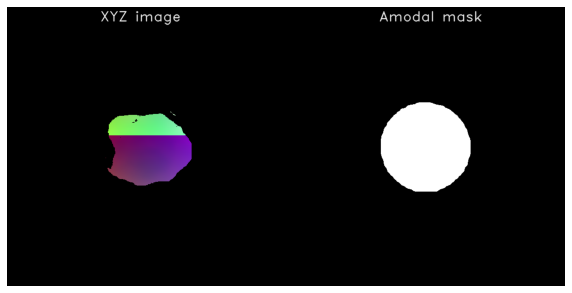

20200819_095900498525_plant1140_rgb_trigger008.png


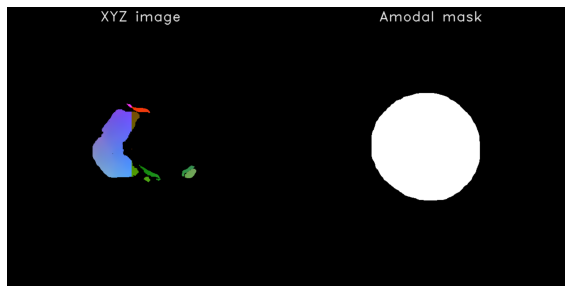

20200819_110821535507_plant1159_rgb_trigger003.png


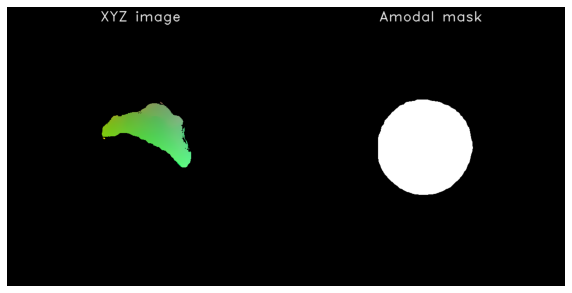

20200819_113732417388_plant1164_rgb_trigger014.png


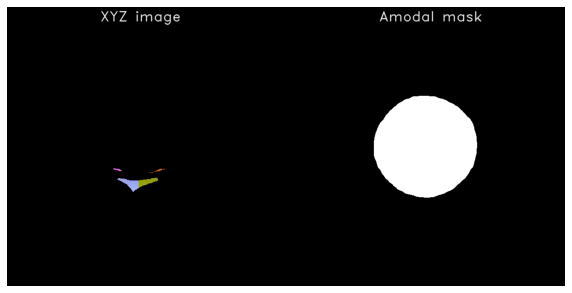

20200819_174349578869_plant1243_rgb_trigger021.png


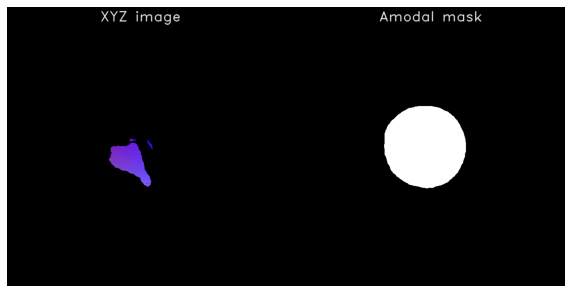

178_Untrimmed_Frame_7_195_rgb.png


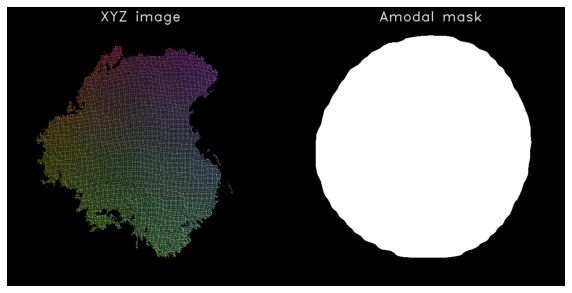

20200713_12422880903_plant1058_rgb_trigger019.png


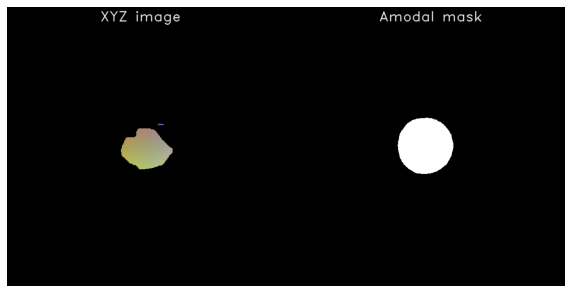

20200819_171651300288_plant1235_rgb_trigger019.png


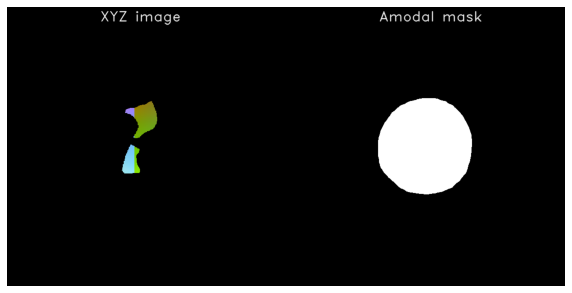

221_Untrimmed_Frame_2_173_rgb.png


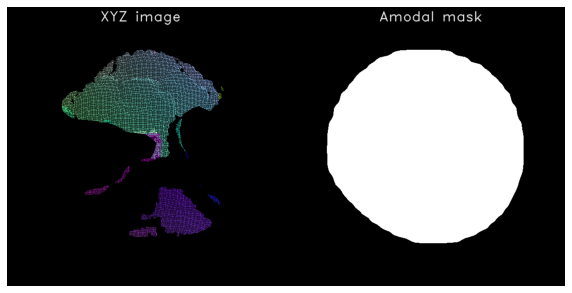

3568_Untrimmed_Frame_1_159_rgb.png


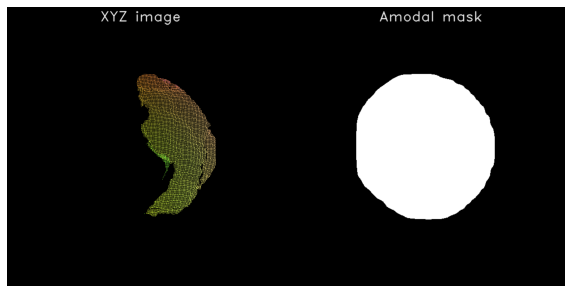

In [9]:
# Initialize the extreme values for normalization
min_x = 0.0
max_x = 0.0
min_y = 0.0
max_y = 0.0
min_z = 9999.9
max_z = 0.0
min_a = 0.0
max_a = 0.0
values = np.array([min_x, max_x, min_y, max_y, min_z, max_z, min_a, max_a]).astype(np.float32)

random_images = []
random_imagenames = []
font_face = cv2.FONT_HERSHEY_DUPLEX
font_scale = 1
font_thickness = 1
text_color1 = [255, 255, 255]

if gt_file_present:
    for j in range(len(subfolders)):
        subfolder = subfolders[j]
        
        writedir = os.path.join(rootdir, store_folder, subfolder)

        if not os.path.exists(writedir):
            os.makedirs(writedir)

        imagefolder = os.path.join(imgfolder, subfolder)
        annotationfile = os.path.join(imagefolder, "annotations.json")
        
        # Register the amodal dataset
        register_coco_instances("broccoli_amodal_" + subfolder, {}, annotationfile, imagefolder)
        broccoli_amodal_metadata = MetadataCatalog.get("broccoli_amodal_" + subfolder)
        dataset_dicts = DatasetCatalog.get("broccoli_amodal_" + subfolder)
        
        ids_visualize = np.random.choice(np.arange(len(dataset_dicts)), 5)

        for i in tqdm(range(len(dataset_dicts))):
            # Load the RGB image
            imgname = dataset_dicts[i]["file_name"]
            basename = os.path.basename(imgname)
            img = cv2.imread(imgname)


            # Load the XYZ image
            xyzimgname = basename.replace("rgb", "xyz")
            xyzimgname = xyzimgname.replace(".png", ".tiff")
            xyzimg = tifffile.imread(os.path.join(xyzimgdir, subfolder, xyzimgname))
            zimg = np.expand_dims(xyzimg[:,:,-1], axis=2)


            # Do the image inference and extract the outputs from Mask R-CNN
            start_time = time.time()
            outputs = predictor(img)
            instances = outputs["instances"].to("cpu")
            classes = instances.pred_classes.numpy()
            scores = instances.scores.numpy()
            boxes = instances.pred_boxes.tensor.numpy()

            # Procedure to check whether we are dealing with ORCNN or MRCNN
            if "pred_visible_masks" in instances._fields:
                amodal_masks = instances.pred_masks.numpy()
                visible_masks = instances.pred_visible_masks.numpy()
            else:
                visible_masks = instances.pred_masks.numpy()


            # Get the ground truth data
            real_diameter = 0
            gt_data_present = False

            for k in range(1, len(gt['groundtruth_measurements_broccoli'])):
                gt_data = gt['groundtruth_measurements_broccoli'][k]
                if gt_data:
                    if gt_data[0] == basename:
                        gt_data_present = True
                        plant_id = gt_data[1]
                        real_diameter = gt_data[2]
                        x_center_gt = gt_data[3]
                        y_center_gt = gt_data[4]
                        coordinates_broccoli_gt = (x_center_gt, y_center_gt)


            # Procedure to load the annotations in case there is no detection 
            d = dataset_dicts[i]
            classes_annot = []
            boxes_annot = []
            amodal_masks_poly = []
            visible_masks_poly = []
            for k in range(len(d["annotations"])):
                classes_annot.append(d["annotations"][k]['category_id'])
                boxes_annot.append(d["annotations"][k]['bbox'])
                amodal_masks_poly.append(d["annotations"][k]['segmentation'])
                visible_masks_poly.append(d["annotations"][k]['visible_mask'])


            # Get the annotations    
            amodal_masks_annot = visualize.make_mask_img(amodal_masks_poly, d['height'], d['width'], "polylines")
            visible_masks_annot = visualize.make_mask_img(visible_masks_poly, d['height'], d['width'], "polylines")


            # Get the bounding box of the broccoli annotation that belongs to the size estimation of the ground truth
            idx = find_closest_object(np.asarray(boxes_annot), "XYWH", coordinates_broccoli_gt, gt_data_present)
            bbox_annot = np.asarray(boxes_annot)[idx]
            class_annot = np.asarray(classes_annot)[idx]


            # Extract the intersection areas between the annotation box and the detected boxes
            if boxes.size > 0:
                int_areas = np.zeros(len(boxes)).astype(np.float32)
                for h in range(len(boxes)):
                    box = boxes[h]
                    cur_class = classes[h]
                    if cur_class == class_annot:
                        int_areas[h] = overlap_area(box, "XYXY", bbox_annot, "XYWH")
            else:
                int_areas = np.zeros(1).astype(np.float32)


            # Get the masks of the detected broccoli head that belongs to the ground truth data
            if np.count_nonzero(int_areas) > 0:
                idx = int_areas.argmax()
                bbox = boxes[idx]
                amodal_mask = np.expand_dims(amodal_masks[idx], axis=2)
                visible_mask = np.expand_dims(visible_masks[idx], axis=2)

            # If there is not a detection that belongs to the ground truth data, use the annotation
            else:
                bbox = [bbox_annot[0], bbox_annot[1], bbox_annot[0]+bbox_annot[2], bbox_annot[1]+bbox_annot[3]]
                amodal_mask = np.expand_dims(amodal_masks_annot[idx], axis=2)
                visible_mask = np.expand_dims(visible_masks_annot[idx], axis=2)


            # Get the XYZ data of the visible mask
            xyzimg_clip = xyzimg[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]),:]
            visible_mask_clip = visible_mask[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]),:]
            xyz_mask = np.multiply(xyzimg_clip, visible_mask_clip)


            # Make a 4-channel image with the XYZ data of the visible mask and the binary amodal mask
            xyza = np.zeros((xyz_mask.shape[0], xyz_mask.shape[1], 4), dtype=np.float32) 
            xyza[:,:,:3] = xyz_mask.astype(np.float32)
            amodal_mask_clip = amodal_mask[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]),:]
            xyza[:,:,3] = amodal_mask_clip.reshape(xyz_mask.shape[0], xyz_mask.shape[1]).astype(np.float32)


            # Apply zeropadding to resize the final mask to a fixed size
            zp = zeropadding(xyza, zeropad_dimension)
            
            
            # Extract the extreme values needed for normalization (when training and infering the regression network)
            values = get_extreme_values(zp, values)
            
            
            # Write the final xyza image and its label
            tifffile.imsave(os.path.join(writedir, xyzimgname), zp)
            
            
            # Write the label
            txt_name = xyzimgname.replace(".tiff", ".txt")
            txtfile = open(os.path.join(writedir,txt_name),"w")
            txtfile.write("{0:.1f}".format(real_diameter))
            txtfile.close()
            
            
            # Store the randomly selected images in an array  
            if i in ids_visualize:               
                xyz_uint8 = zp[:,:,:3].astype(np.uint8)
                height, width = xyz_uint8.shape[:2]

                text_pt4 = (int((width/2) - 100), 30)
                text_str4 = "XYZ image"
                text_w4, text_h4 = cv2.getTextSize(text_str4, font_face, font_scale, font_thickness)[0]
                cv2.putText(xyz_uint8, text_str4, text_pt4, font_face, font_scale, text_color1, font_thickness, cv2.LINE_AA)

                a1_uint8 = np.multiply(np.expand_dims(zp[:,:,3].astype(np.uint8), axis=2), 255)
                a3_uint8 = np.repeat(a1_uint8, 3, axis=2)
                text_str5 = "Amodal mask"
                text_w5, text_h5 = cv2.getTextSize(text_str5, font_face, font_scale, font_thickness)[0]
                cv2.putText(a3_uint8, text_str5, text_pt4, font_face, font_scale, text_color1, font_thickness, cv2.LINE_AA)

                xyza_mosaic = np.hstack((xyz_uint8, a3_uint8))
                random_imagenames.append(basename)
                random_images.append(xyza_mosaic)
                

# Visualize the results
for j in range(len(random_images)):
    image_name = random_imagenames[j]
    print(image_name)
    image = random_images[j]
    imshow(image)

In [10]:
# Write the normalization values so it can be used for regression training and inference
writedir = os.path.join(rootdir, store_folder)
if not os.path.exists(writedir):
    os.makedirs(writedir)

txtfile = open(os.path.join(writedir,"normalization_values.txt"),"w")
for value in values:
    txtfile.write("{0:.2f}".format(value))
    txtfile.write("\r\n")
txtfile.close()